### CS/ECE/ISyE 524 &mdash; Introduction to Optimization &mdash; Spring 2018 ###

# Making Miracles Happen Overnight: 24-Hour Shipping #

#### Evan Hernandez (ehernandez4@wisc.edu), Saman Tabatabai (tabatabai@wisc.edu), William Jen (wjen@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
    1. [Single Package, Single MOT](#2.A.-Single-Package,-Single-MOT)
    1. [Single Package, Many MOTs](#2.B.-Single-Package,-Many-MOTs)
    1. [Many Packages, Single MOT](#2.C.-Many-Packages,-Single-MOT)
    1. [Many Packages, Many MOTs](#2.D.-Many-Packages,-Many-MOTs)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
1. [Conclusion](#5.-Conclusion)
1. [References](#6.-References)

## 1. Introduction ##

At some point, you probably needed to receive a package as soon as possible. Maybe you were driving to Niagara Falls from Boston, and realized at the Canadian border that you forgot your passport. Maybe your wedding was one day away, and you still needed an essential piece of decor. Or, if you were really unlucky, you were unconscious in a Des Moines ICU, and the medicine you needed was only available in Seattle. All of these unfortunate situations are remedied by overnight shipping services, thanks to companies like FedEx and UPS.

Today, people across the United States may request overnight package delivery for a nominal fee. As great as this is, one has to wonder: how can such a service be economically viable for shipping companies? The task is certainly _feasible_. For example, in the United States, a flight from Miami to Alaska requires only 12 hours, which leaves ample time for sorting and delivery. However, the logistics could be exorbitantly expensive if not properly planned. Companies undoubtedly want to avoid sending each package on a separate flight. More to the point, companies probably prefer to operate as few flights as possible on any given day.

Neither overnight shipping nor the challenges described above are new. FedEx began operating in April of 1973, and at the time delivered only 186 overnight packages using 14 cargo planes. Now, FedEx services nearly 10 million overnight packages per day, and is renowned for its innovative shipping technologies, which include the tracking number. FedEx offers overnight shipping from Seattle, WA, to Portland, ME; from Miami, FL, to Anchorage, AK; and even from Edinburgh, Scotland to anywhere in the United States.

Both UPS and FedEx operate a number of hubs. These hubs receive packages from nearby delivery points and transfer them to other hubs via daily cargo flights. For both companies, most packages run through primary hubs, located near the population mean of the United States in Memphis, TN and Louisville, KY, respectively. Everyday at around the same time, cargo planes from across the country arrive at the primary hub and unload hundreds of thousands of packages. The packages are automatically sorted and then transferred to other hubs near their destination. Finally, the packages are delivered to their recipients using cheaper methods of transportation, such as trucks and small propeller planes.

<p style="text-align: center">
<img
    alt="US Population Mean"
    src="https://upload.wikimedia.org/wikipedia/commons/a/a0/US_Mean_Center_of_Population_1790-2010.PNG"
>
<em>Drift of United States mean population center. Taken from [Wikipedia](https://upload.wikimedia.org/wikipedia/commons/a/a0/US_Mean_Center_of_Population_1790-2010.PNG)</em>.
</p>

In the present report, we imagine we are a new shipping company with hubs in every city. Each hub connects to other hubs via different methods of transportation (trucks, flights, trains, etc.). We address the following question: how can we transfer packages between hubs to guarantee overnight delivery while minimizing transportation costs? 
Ultimately, we model overnight shipment planning as a network flow problem. We then compute an optimal shipping plan on synthetic data taken in part from the Google Maps API.

## 2. Mathematical model ##

We begin with a general construction of the problem. Suppose we wish to provide shipping services to $N$ cities, and we have access to $M$ methods of transportation (MOT). At the start of every day, we receive $P$ packages from arbitrary cities with arbitrary destinations. We guarantee delivery of each package from source to destination within $T$ hours. Our goal is to construct a feasible $T$-hour shipping plan that minimizes transportation cost.

Let the set of cities be denoted $V = \{v_1, \dots, v_N\}$, and let $e_{ij} \in V^2$ denote the edge between city $i$ and city $j$. To each such edge we attach a distance $d_{ij}$ in miels as the bird flies. For $k=1,\dots,M$ let the routes of the $k$-th MOT be given by the edge set $E_k \subseteq V^2$, and to each MOT associate an average speed $s_k$ in miles per hour, a fixed operating cost $f_k$, and a cost per unit of flow $c_k$. We also associate a multiplier $m_k$ to account for differences in distances between MOTs (e.g., trucks have more miles to cover than flights in general because they are restricted to roadways).

We make the following assumptions:
- Shipping begins immediately at the start of the day.
- There is one hub in every city.
- Hubs sort each package upon arrival. Sorting requires a constant $t$ hours for each package at each hub. Packages may be sorted concurrently.
- Once packages arrive in their destination city, they are delivered instantly after sorting.
- Transportation time scales linearly with distance and includes sorting time at the destination. In other words, if $e_{ij} \in E_k$, then the travel time for that edge is given by $d_{ij} s_k m_k + t$.
- Transportation cost scales linearly with capacity. In other words, if $e_{ij} \in E_k$ and $n$ packages flow over $e_{ij}$ for MOT $k$, then the cost is exactly $(n c_k + f_{k})m_kd_{ij}$.
- There is a feasible route between each pair of cities, i.e., a route whose travel time is less than $T$. This is a reasonable assumption in practice. For example, in the United States, you can fly between any two cities in less than 12 hours.
- Each package is transported to the next hub immediately after sorting. This assumption would be impractical in reality because each MOT can and should carry many packages. We make the assumption here for simplicity. The problem is significantly more difficult if a route does not launch until the hub receives every package scheduled for it. Furthermore, we care more about package flow than exact timing. The logistics of departure times could be planned separately, and we may factor departure wait times into our speed variables $s_k$ to obtain a conservative shipping plan.
- Each edge has unlimited capacity. We assume this because, if it is profitable, we may devote arbitrarily many trucks/flights/etc. to a given hub.

We will model and solve four variants of the overnight shipping problem, starting with the simplest instance. As we will see, the overnight shipping problem boils down to traditional variants of network flow. We will assign values to the variables in the [Solution](#3.-Solution) selection.

### 2.A. Single Package, Single MOT ###

We begin by considering overnight shipping where there is only one package to deliver, and only one MOT with which to deliver it. This amounts to finding the shortest path between the package source and destination. Indeed, because there is only one MOT, we do not need to factor in the MOT costs, as they are evenly proportional to $d_{ij}$. We also assumed that there exists a feasible path between the source and the destination, so the minimal distance path must satisfy the time constraint and we may therefore exclude it from our formulation.

Let the package source node be $u$ and the destination node be $v$. Let $A \in \mathbb{R}^{|V| \times |E|}$ denote the incidence matrix of the graph and let $b \in \mathbb{R}^{|V|}$ be the vector with value 1 at $u$'s position, -1 at $v$'s position, and 0 everywhere else. (That is, $b$ is a balance ledger requiring $u$ to supply 1 unit of flow and $v$ to demand 1 unit of flow.) Finally, let the decision variable $x \in \mathbb{R}^{|E|}$ denote the flow along each edge and let the constant $d \in \mathbb{R}^{|E|}$ denote the distance associated with each edge. The flow balance constraint is succinctly represented as $Ax = b$ and the objective as $d^\text{T}x$.

We obtain the following optimization problem:

\begin{align*}
& \underset{x}{\text{minimize}} & d^\text{T}x \\
& \text{subject to} &  Ax = b \\
&& x \ge 0
\end{align*}

There is one catch. We would like to treat the above as a linear program, but we require an integral solution. Thankfully, our only constraint is given by a totally unimodular incidence matrix, so all vertices of the polyhedron given by $Ax = b$ have integer coordinates.

### 2.B. Single Package, Many MOTs ###

We may readily extend (2a) to allow for multiple MOTs. It (almost) suffices to consider $E = \bigcup_{k=1}^M E_i$ and repeat the procedure from (2a) on the graph $(V, E)$. However, we must make two modifications.

First, travel time is now no longer evenly proportional to $d_{ij}$. Instead, transporting the package between cities $i$ and $j$ with MOT $k$ requires $d_{ij}m_ks_k + t$ hours. Let $\tau \in \mathbb{R}^{|E|}$ denote the vector of times required to travel across each edge. We constrain that the total travel time, given by $\tau^\text{T}x$, is no more than $T$.

Second, and analogous to the above, cost is no longer evenly proportional to $d_{ij}$. Luckily, because only one unit of flow will be passed along each edge, we do not need to distinguish the fixed costs $f_k$ and the flow costs $c_k$.  In this regime, we associate to each edge $e_{ijk} \in E_k$ the cost $(f_k + c_k)m_kd_{ij}$. Grouping all such costs into a vector $\alpha \in \mathbb{R}^{|E|}$, our new objective is to minimize $\alpha^\text{T}x$.  

Letting $A$, $b$, and $x$ be as before, the optimization problem becomes:

\begin{align*}
& \underset{x}{\text{minimize}} & \alpha^\text{T}x \\
& \text{subject to} &  Ax = b \\
&& \tau^\text{T}x \le T \\
&& x \in \{0,1\}^{|E|}
\end{align*}

Unfortunately, the addition of the time constraint means we are not guaranteed integral solutions, so we must add the integrality constraint that $x$ be binary, and solve an MIP instead of an LP.

### 2.C. Many Packages, Single MOT ###

We model this as a <b>multiple commodity network flow (MCNF)</b> problem. In MCNF problems, we distinguish the flow of several commodities. Each node has a balance ledger for each commodity. Some nodes supply a specific commodity, while others demand it. The objective is to ensure the demands for each commodity are met while respecting edge capacities and minimizing flow costs.

In our case, the commodities are packages $p_i = (u_i, v_i)$ where $u_i$ is the source and $v_i$ is the sink. To each package we associate a separate decision variable $x_i \in \{0, 1\}^{|E|}$, which denotes the flow of the package, as well as a balance ledger $b_i$, defined in the same way as in (2a). For notational convenience, let $f, c, \tau \in \mathbb{R}^{|E|}$ denote the fixed cost, the cost per flow, and the travel time of each edge, respectively, and let $A$ be the incidence matrix for the graph as in (2a).

There are several issues to address. First, we need to ensure that all packages arrive within the deadline. We do this by constraining that $\tau^\text{T}x_i \le T$ for all $i$. Second, although we have only one MOT, we must consider the fixed cost of using each edge as well as the cost per flow. We introduce the binary vector $z \in \{0, 1\}^{|E|}$ to keep track of when an edge is used, and for $j = 1,\dots,|E|$ enforce the logical constraint $\sum_{i=1}^P (x_i)_j > 0 \Rightarrow z_j = 1$ using the big-$M$ trick on the contrapositive with $P$ as the obvious upper bound. We may then readily factor the fixed cost $f^\text{T}z$ into our objective function, in addition to the traditional flow cost $\sum_{i=1}^Pc^\text{T}x_i$.

We obtain the following optimization problem:

\begin{align*}
& \underset{z, x_i}{\text{minimize}} & f^\text{T}z + \sum_{i=1}^P c^\text{T}x_i \\
& \text{subject to} & \sum_{i=1}^P x_i \le Pz \\ 
&& A x_i = b_i \text{ for } i=1,\dots,P \\
&& \tau^\text{T}x_i \le T \text{ for } i=1,\dots,P \\
&& x_i \in \{0,1\}^{|E|} \text{ for } i=1,\dots,P \\
&& z \in \{0,1\}^{|E|}
\end{align*}

Unfortunately, MCNF problems are significantly harder to solve than ordinary network flow problems, even with only two commodities. This is because we must constrain the $x_i$ (as well as $z$) to be binary, which elevates the original LP to an MIP.

### 2.D. Many Packages, Many MOTs ###

We apply the same modifications from (2b). The resulting optimization problem is the same as in (2c), but we redefine the edge set to be $E = \bigcup_{i=1}^M E_i$.

## 3. Solution ##
### 3.A. Installing Prerequisite Libraries

#### JuMP, NamedArrays, Gurobi, PyPlot
Since these packages were used in class, no additional installation instructions will be given.

#### Matplotlib.Basemap
Basemap is used to overlay paths between US cities to better visualize the shipping process. However, it's a
tad complicated to install.

##### Windows
Go [here](https://www.lfd.uci.edu/~gohlke/pythonlibs/#basemap) for a pre-built python wheel. Select the correct
wheel file for your python version and system architecture, and install by:
`pip install <wheel file>`

If you installed Basemap using your local python installation instead of your Julia Python install, open up the Julia 
command prompt and run the following:
```Julia
ENV["PYTHON"] = "C:\\path\\to\\your\\python.exe"
Pkg.build("PyCall")
```

This points Julia to use your local python install instead of the bundled one. It may also rebuild PyPlot after this as
well.

##### &ast;Nix
See the official documentation to build from source [here](https://matplotlib.org/basemap/users/installing.html#dependencies).

## 3.B Parsing MOT Data

In this project, three MOTs are examined: air, truck, and train. To represent the distances between cities, we require
an adjacency matrix $M_{ij}$ where $i$ is the source city, $j$ is the destination city, and $M_{ij}$ is the distance
between those cities. To model a broken link, we chose an arbitrarily high distance ($1 \times 10^{12}$ miles).

Air travel is assumed to be straight, and was pulled from [this website](http://www.mapcrow.info/united_states.html).
Since direct air routes do not always exist between any two cities, we arbitrarily chose air routes between cities. 
The create_air_distances.py python script in the scripts/ folder generates this CSV file.

Road travel is queried directly from the Google Maps Distance Matrix API. Once again, we chose arbitrary road routes
between cities. The create_road_distances.py python script in the scripts/ folder generates this CSV file.

Finally, train travel is assumed to be some 1.3 times the direct air mileage. Train routes are loosely based on
the [Class 1 railroad system](http://archive.freightrailworks.org/network/class-i/). The create_train_distances.py
python script in the scripts/ folder generates this CSV file.

A bit of warning if you are generating your own CSV files - Julia is rather fussy about its CSV files, so you may
need to open the file in Excel and resave it. It's bizarre, but that's just how it is.

Cities: 

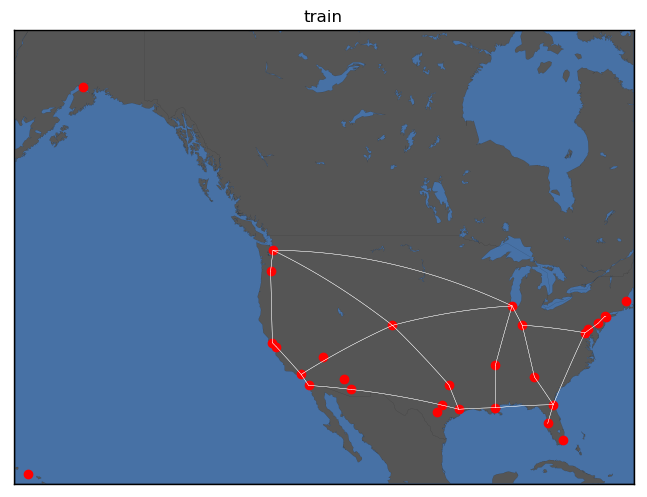

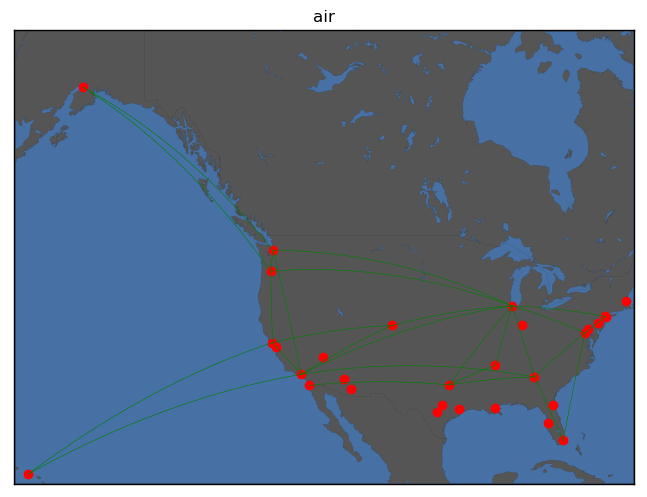

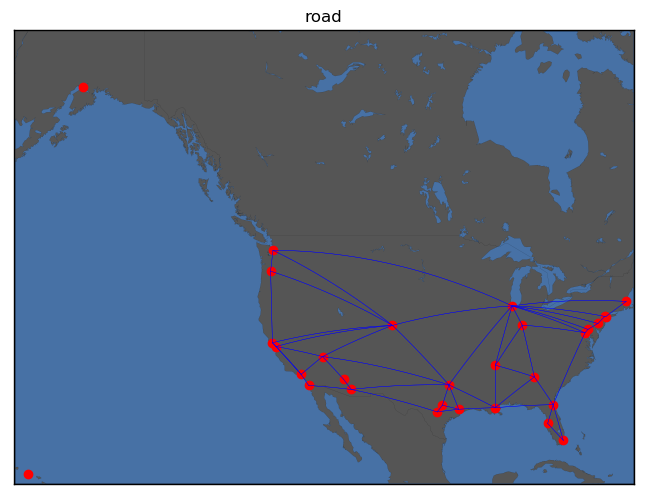

Any["Anchorage", "Atlanta", "Austin", "Baltimore", "Boston", "Chicago", "Dallas", "Denver", "Honolulu", "Houston", "Indianapolis", "Jacksonville", "Las Vegas", "Los Angeles", "Memphis", "Miami", "New Orleans", "New York City", "Newark", "Philadelphia", "Phoenix", "Portland", "San Antonio", "San Diego", "San Francisco", "San Jose", "Seattle", "Tampa", "Tucson", "Washington DC"]


In [1]:
using JuMP, NamedArrays, PyCall, PyPlot
@pyimport mpl_toolkits.basemap as basemap

"""
Given a dictionary of MOT names to MOT CSV files and
a file containing each city's latitude and longitude,
parse those CSV files. 
"""
function parse_mots(mot_file_dict, location_csv)
    # first, parse city locations
    # assumption: all cities are in each file
    raw_location = readcsv(location_csv)
    city_names = raw_location[2:end, 1]
    latitudes = Dict(zip(city_names, raw_location[2:end, 2]))
    longitudes = Dict(zip(city_names, raw_location[2:end, 3]))
    
    mot_distance_dict = Dict()
    for (mot_name, mot_filename) in mot_file_dict
        raw_distances = readcsv(mot_filename)
        
        # remove 1 since the first row and column are headers
        distances = zeros(size(raw_distances) .- 1)
        for i in 2:(size(raw_distances)[1])
            distances[i - 1, :] = raw_distances[i, 2:end]
        end
        mot_distance_dict[mot_name] = NamedArray(distances, (city_names, city_names))
    end
    
    return city_names, latitudes, longitudes, mot_distance_dict    
end

function get_basemap(city_names, latitudes, longitudes)
    plt[:figure](figsize=(8, 16))

    # create the US basemap and set general appearance
    m = basemap.Basemap(
        projection="merc",
        resolution="l",
        llcrnrlat=20,
        llcrnrlon=-160,
        urcrnrlat=65,
        urcrnrlon=-70)
    m[:drawmapboundary](fill_color="#4771a5")
    m[:fillcontinents](color="#555555")
    m[:drawcoastlines](linewidth=0.05)
    m[:drawcountries](linewidth=0.05)

    # plot each city on the map
    for i in city_names
        x, y = m(longitudes[i], latitudes[i])
        m[:plot](x, y, "ro")
    end
    
    return m
end

"""
Given the parsed data from parse_mots, create a plot for each MOT where each
connected edge is overlayed on the US map.
"""
function plot_all_mots(city_names, latitudes, longitudes, mot_dict, colors)
    for (mot, color) in zip(keys(mot_dict), colors)
        m = get_basemap(city_names, latitudes, longitudes)
        plt[:title](mot)

        # draw each active edge between cities
        for i in city_names
            distances = mot_dict[mot]
            for j in city_names
                if i == j || distances[i, j] <= 0 || distances[i, j] >= 1e9
                    continue
                end

                m[:drawgreatcircle](
                    longitudes[i], latitudes[i], longitudes[j], latitudes[j],
                    linewidth=0.25, color=color, linestyle="-")
            end
        end
    end
    
    plt[:show]()
end

mot_dict = Dict(
    "air" => "air_distances.csv",
    "road" => "road_distances.csv",
    "train" => "train_distances.csv"
)

MOT_COLORS = ["w", "g", "b"]

cities, latitudes, longitudes, mot_distances = parse_mots(mot_dict, "cities_latlong.csv")
plot_all_mots(cities, latitudes, longitudes, mot_distances, MOT_COLORS)
println("Cities: ", cities)

## 3.C. Single Package, Single MOT

Academic license - for non-commercial use only
Optimal


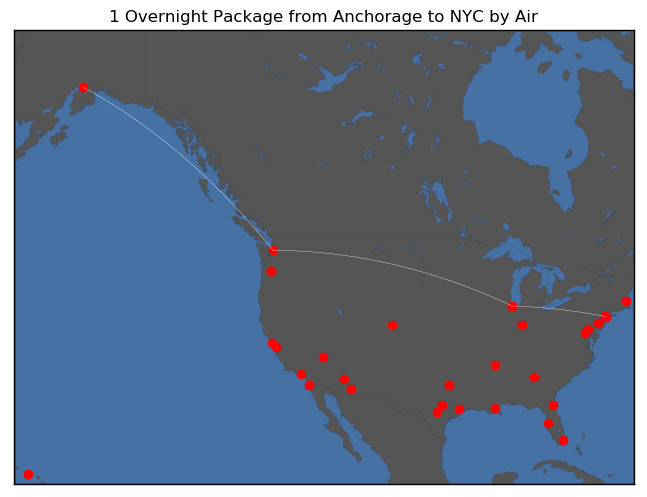

11.897716666666668 hours.


In [2]:
using Gurobi

"""
Plots the path taken by one package through the cities.
"""
function plot_spsm(path, title, start_index, end_index, city_names, latitudes, longitudes)
    m = get_basemap(city_names, latitudes, longitudes)
    plt[:title](title)
    
    current_index = start_index
    while current_index != end_index
        next_index = findfirst(path[current_index, :], 1)
        m[:drawgreatcircle](
            longitudes[city_names[current_index]], 
            latitudes[city_names[current_index]], 
            longitudes[city_names[next_index]],
            latitudes[city_names[next_index]],
            linewidth=0.25, color="w", linestyle="-"
        )
        current_index = next_index
    end
    
    plt[:show]()
end

AVG_AIRSPEED = 600 # average airplane cruise speed in mph
SORTING_TIME = 0.5 # 30 min for sorting

spsm_distances = mot_distances["air"] # air
start_city = findfirst(cities, "Anchorage")
end_city = findfirst(cities, "New York City")
num_cities = length(cities)

m = Model(solver = GurobiSolver(OutputFlag = false))
@variable(m, spsm[1:num_cities, 1:num_cities], Bin) # spsm = single package, single MOT
@expression(m, total_time, sum((spsm_distances / AVG_AIRSPEED + SORTING_TIME) .* spsm))
@constraint(m, [i in 1:num_cities], spsm[i, i] == 0) # no self loops
@constraint(m, total_time <= 24)

# starting city only has outward flow
@constraint(m, sum(spsm[start_city, :]) == 1)
@constraint(m, sum(spsm[:, start_city]) == 0)

# ending city only has inward flow
@constraint(m, sum(spsm[:, end_city]) == 1)
@constraint(m, sum(spsm[end_city, :]) == 0)

# all other cities must have balanced flow
for i in 1:num_cities
    if i != start_city && i != end_city
        @constraint(m, sum(spsm[i, :]) == sum(spsm[:, i]))
    end
end

# min time == min distance == min cost
@objective(m, Min, total_time)
              
status = solve(m)
println(status)
println(getobjectivevalue(m), " hours.")

plot_spsm(
    getvalue(spsm),
    "1 Overnight Package from Anchorage to NYC by Air",
    start_city,
    end_city,
    cities,
    latitudes,
    longitudes
)

## 3.D. Single Package, Multiple MOTs

When we introduce multiple MOTs, we need to factor in the differing costs per MOT.

The train average fuel efficiency is given to be somewhere in the 400-500 ton-miles per gallon range, meaning
that trains are able to carry one ton of freight 400-500 miles on one gallon of fuel. Note that this is an average
and that this statistic comes from [CSX](https://www.csx.com/index.cfm/about-us/the-csx-advantage/fuel-efficiency/?mobileFormat=true), 
a freight company. Similarly, trucks are estimated to have around 100 ton-miles per gallon. 

A [WikiCommons graphic](https://commons.wikimedia.org/wiki/File:Freight_Ton_Miles_per_Gallon.svg) appears to provide
reasonable values for ton-miles per gallon for various MOTs. The low ton-miles per gallon for aircraft is plausible
as air freight has a low capacity for a comparatively high fuel usage.

Trains and trucks usually run on diesel. Diesel prices from the [US Energy Information Administration](https://www.eia.gov/petroleum/gasdiesel/) were used. Jet fuel prices were sourced from the [IATA](http://www.iata.org/publications/economics/fuel-monitor/Pages/index.aspx).

For convenience, we assume that our single package weighs a single ton.

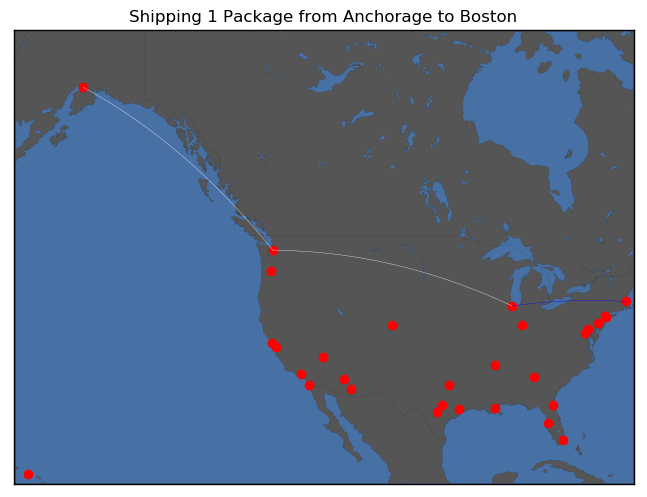

Academic license - for non-commercial use only
Optimal
Overnight cost: $1060.9598597402596
Package time: 23.854533333333336 hours.


In [3]:
"""
Plots a package's path in the US, color coded by MOT.
"""
function plot_spmm(path, title, start_index, end_index, city_names, latitudes, longitudes, colors)
    m = get_basemap(city_names, latitudes, longitudes)
    plt[:title](title)
    
    current_index = start_index
    while current_index != end_index
        # The path is a 3D matrix M_{ijk} where i is the src, j is the dst, and k is the MOT
        # The current index is the src city. We slice this into an matrix C_{ij} where
        # i is the sink city and j is the MOT
        current_city = path[current_index, :, :]
        
        # to determine the sink city, we sum the prior C_{ij} along the column dimension
        # so we get a column vector representing the sums of each row. The resultant vector
        # will only have 1 row that will be nonzero. We can therefore run findfirst() to grab
        # the sink city. After that, we can slice that specific row, and grab the MOT index. 
        next_index = findfirst(sum(current_city, 2), 1)
        mot_index = findfirst(current_city[next_index, :], 1)
        m[:drawgreatcircle](
            longitudes[city_names[current_index]], 
            latitudes[city_names[current_index]], 
            longitudes[city_names[next_index]],
            latitudes[city_names[next_index]],
            linewidth=0.25, color=colors[mot_index], linestyle="-"
        )
        current_index = next_index
    end
    
    plt[:show]()
end

start_city = findfirst(cities, "Anchorage")
end_city = findfirst(cities, "Boston")
mot_list = ["air", "train", "road"]

mpg = [10.5, 413, 110] # air, train, truck ton-miles per gal
fuel = [2.13, 3.1, 3.1] # air, train, truck $/gal. Pulled from EIA
fixed_costs = fuel ./ mpg # air, train, truck $/mi based on fuel usage only
speed = [550, 50, 75] # air, train, truck average mph

# overlay the MOT distance matrices into a 3D matrix
combined_distances = cat(
    [0, 0, length(mot_distances)],
    reshape(convert(Array, mot_distances["air"]), (num_cities, num_cities)),
    reshape(convert(Array, mot_distances["train"]), (num_cities, num_cities)),
    reshape(convert(Array, mot_distances["road"]), (num_cities, num_cities))
)

# overlay the fixed costs and speeds into a 3D matrix
# Given a matrix M_{ijk}, M_{ij} for all k = 1..# MOTs
# is the same value. 
fixed_costs_matrix = zeros(size(combined_distances))
speed_matrix = zeros(size(combined_distances))
for i in 1:num_cities
    for j in 1:num_cities
        fixed_costs_matrix[i, j, :] = fixed_costs
        speed_matrix[i, j, :] = speed
    end
end

m = Model(solver=GurobiSolver(OutputFlag=false))
@variable(m, spmm[1:num_cities, 1:num_cities, 1:length(mot_distances)], Bin)

# no self loops
@constraint(m, [i in 1:num_cities], sum(spmm[i, i, :]) == 0) 
@expression(m, total_time, sum((combined_distances ./ speed_matrix .+ SORTING_TIME) .* spmm))
@constraint(m, total_time <= 24)

# starting city only has outward flow
@constraint(m, sum(spmm[start_city, :, :]) == 1)
@constraint(m, sum(spmm[:, start_city, :]) == 0)

# ending city only has inward flow
@constraint(m, sum(spmm[:, end_city, :]) == 1)
@constraint(m, sum(spmm[end_city, :, :]) == 0)

# all other cities must have balanced flow
for i in 1:num_cities
    if i != start_city && i != end_city
        @constraint(m, sum(spmm[i, :, :]) == sum(spmm[:, i, :]))
    end
end

# minimize cost by multiplying fixed_costs (unit: $/mi) and distances
@objective(m, Min, sum(combined_distances .* spmm .* fixed_costs_matrix))
status = solve(m)
println(status)
println("Overnight cost: \$", getobjectivevalue(m))
println("Package time: ", getvalue(total_time), " hours.")
plot_spmm(
    getvalue(spmm),
    "Shipping 1 Package from Anchorage to Boston",
    start_city,
    end_city,
    cities,
    latitudes,
    longitudes,
    MOT_COLORS
)

## 3.E. Multiple Packages, Single MOT

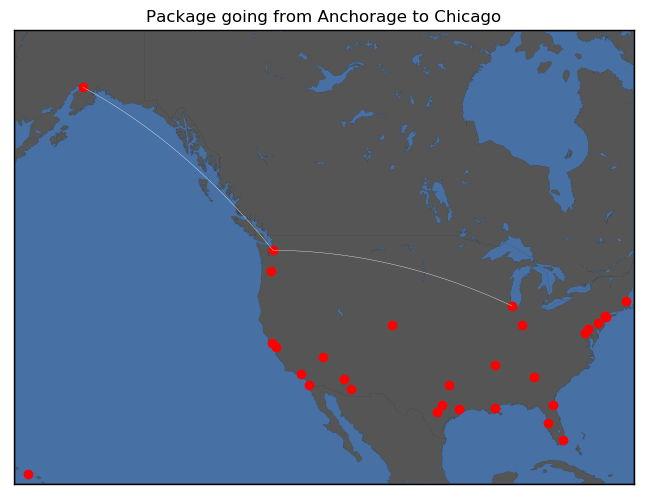

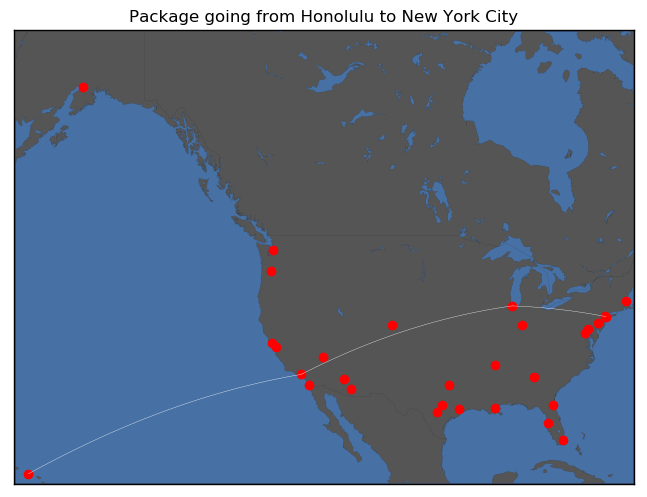

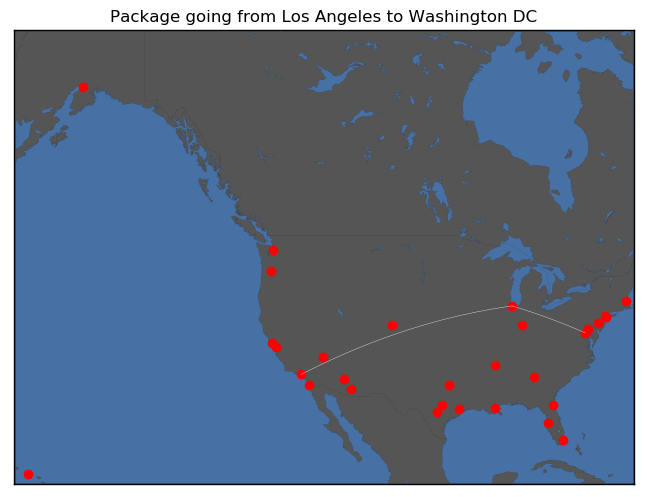

Academic license - for non-commercial use only
Optimal
[9.48943, 14.9363, 7.25927]


In [12]:
"""
Given an array of packages with a starting and ending city, convert them
into indices.
"""
function convert_pkgs(packages, cities)
    return [[findfirst(cities, i[1]), findfirst(cities, i[2])] for i in packages]
end

function plot_mpsm(path, pkgs, title, city_names, latitudes, longitudes)    
    for i in 1:length(pkgs)
        start_index, end_index = pkgs[i]
        start_city = cities[pkgs[i][1]]
        end_city = cities[pkgs[i][2]]
        pkg_path = path[i, :, :]
        pkg_color = rand(3,)
        
        plot_spsm(pkg_path, "Package going from " * start_city *  " to " * end_city,
            start_index, end_index, city_names, latitudes, longitudes)
    end
    
    plt[:show]()
end

pkgs = [
    ["Anchorage", "Chicago"],
    ["Honolulu", "New York City"], 
    ["Los Angeles", "Washington DC"]
]

pkgs = convert_pkgs(pkgs, cities)

mpsm_distances = mot_distances["air"]

m = Model(solver = GurobiSolver(OutputFlag = false))
@variable(m, mpsm[1:length(pkgs), 1:num_cities, 1:num_cities], Bin)

# no self loops
@constraint(m, [i in 1:length(pkgs), j in 1:num_cities], mpsm[i, j, j] == 0)

# for each package, time limit = 24 hours
@expression(m, total_time[i in 1:length(pkgs)], 
    sum((mpsm_distances / AVG_AIRSPEED + SORTING_TIME) .* mpsm[i, :, :]))
@constraint(m, total_time .<= 24)

# each package's starting city has outward flow
@constraint(m, [i in 1:length(pkgs)], sum(mpsm[i, pkgs[i][1], :]) == 1)
@constraint(m, [i in 1:length(pkgs)], sum(mpsm[i, :, pkgs[i][1]]) == 0)

# each package's ending city has inward flow
@constraint(m, [i in 1:length(pkgs)], sum(mpsm[i, :, pkgs[i][2]]) == 1)
@constraint(m, [i in 1:length(pkgs)], sum(mpsm[i, pkgs[i][2], :]) == 0)

# all other cities for each package have balanced flow
for i in 1:length(pkgs)
    start_city, end_city = pkgs[i]
    for j in 1:num_cities
        if j != start_city && j != end_city
            @constraint(m, sum(mpsm[i, j, :]) == sum(mpsm[i, :, j]))
        end
    end
end

# minimize total time taken by each package == min distance == min cost
@objective(m, Min, sum(total_time));

status = solve(m)
println(status)
println(getvalue(total_time))
plot_mpsm(
    getvalue(mpsm), 
    pkgs, 
    "3 Packages via Air", 
    cities, 
    latitudes, 
    longitudes
)

## 3.F. Multiple Packages, Multiple MOTs

## 4. Results and discussion ##

Here, you display and discuss the results. Show figures, plots, images, trade-off curves, or whatever else you can think of to best illustrate your results. The discussion should explain what the results mean, and how to interpret them. You should also explain the limitations of your approach/model and how sensitive your results are to the assumptions you made.

Use plots (see `PyPlot` examples from class), or you can display results in a table like this:

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
| col 3 is      | right-aligned |\$1600 |
| col 2 is      | centered      |  \$12 |
| zebra stripes | are neat      |   \$1 |

### 4.A. Feel free to add subsections

#### 4.A.a. or subsubsections

## 5. Conclusion ##

In this report, we have discussed methods for constructing a profitable overnight shipping plan using multiple methods of transportation. We showed in our [mathematical formulation](#2.-Mathematical-model) that we may adequately model overnight shipment planning as a network flow problem, particularly when only one MOT and one package is involved. When multiple packages are involved, we must elevate to a multiple commodity flow model, which is a mixed integer program. We implemented this model and ran it on a small dataset of 30 cities with arbitrarily placed connections, and we ultimately showed that our model produces reasonable shipping plans by consolidating packages from remote locations to large hubs, where they are forwarded to another large hub through fast but expensive MOTs such as cargo planes. 

While we made many assumptions about transportation costs and timing, our model sets a strong foundation for more detailed models that incorporate more domain knowledge. With this in mind, we offer several directions for future work.

**How much should we charge for delivery?** Suppose we know the distribution of overnight shipment origins throughout the United States (e.g., 10% come from New York, 5% from Seattle, 1% from Portland, etc.). How much should we charge for each package to ensure a profit? To solve this, we could estimate how many packages in total we must deliver on a given day, assign them random sources and estinations according to the distribution, and run our multiple-package, multiple-MOT network flow model on that data. We could repeat that step many times and average the estimated shipping cost for the day. We could use that average cost to determine how much to charge per package. Then we could enforce upcharges or downcharges at each city depending on how many packages originate or land there.

**Relaxing assumptions.** The biggest assumption we made was that packages leave a hub as soon as they are sorted. In reality, at each hub we would want to schedule all packages destined for the same outgoing route to arrive almost simultaneously. This would guarantee that the route carries all its packages at once. Unfortunately, modifying the time constraint to account for the arrival time of each package at each hub is extremely complicated. If nothing else, it is nonlinear because it requires taking the maximum of the travel times of all incoming paths to the hub &mdash; and those travel times, recursively, are a maximum of travel times, and so forth. We would require an entirely different model of the problem, or we would have to settle for an approximation. Alternatively, we could use the MCNF model we presented here, and then use dynamic programming to validate that the result fits our complicated constraint.

## 6. References ##

1. FedEx Corporate. _Connecting People and Possibilities: The History of FedEx_. Accessed at https://about.van.fedex.com/our-story/history-timeline/history/.
1. Roberto Baldwin. _Shipshape: Tracking 40 Years Of FedEx Tech_. Accessed at https://www.wired.com/2013/04/40-years-of-fedex/.
1. Wendover Productions. _How Overnight Shipping Works_. Accessed at https://www.youtube.com/watch?v=y3qfeoqErtY.
1. Wikipedia. _Mean Center Of The United States Population_. Accessed at https://en.wikipedia.org/wiki/Mean_center_of_the_United_States_population.